In [8]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


[I 2025-06-18 12:14:13,472] A new study created in memory with name: no-name-0ee3938d-818b-4479-8186-f5b9dc120545
C:\Users\griff\anaconda3.1\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:14:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\griff\anaconda3.1\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:14:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\griff\anaconda3.1\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:14:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-06-18 12:14:15,014] Trial 0 finished with value: 0.637063506768042 and parameters: {'n_estimators': 9

AUC: 0.6849430927915503
Accuracy: 0.6238962472406181
Brier Score: 0.22185634643444807
Confusion Matrix:
 [[1273  593]
 [ 770  988]]
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.68      0.65      1866
           1       0.62      0.56      0.59      1758

    accuracy                           0.62      3624
   macro avg       0.62      0.62      0.62      3624
weighted avg       0.62      0.62      0.62      3624



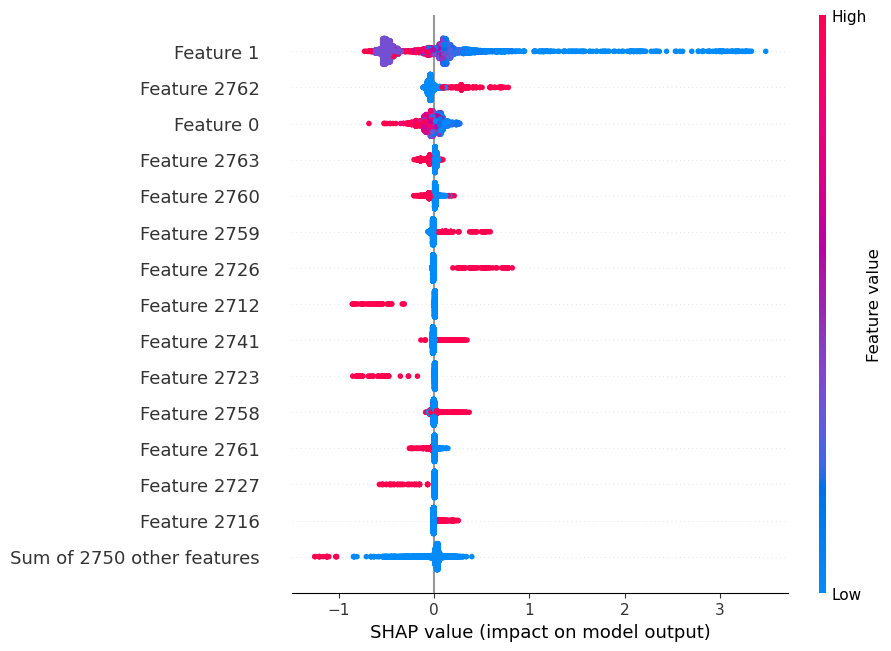

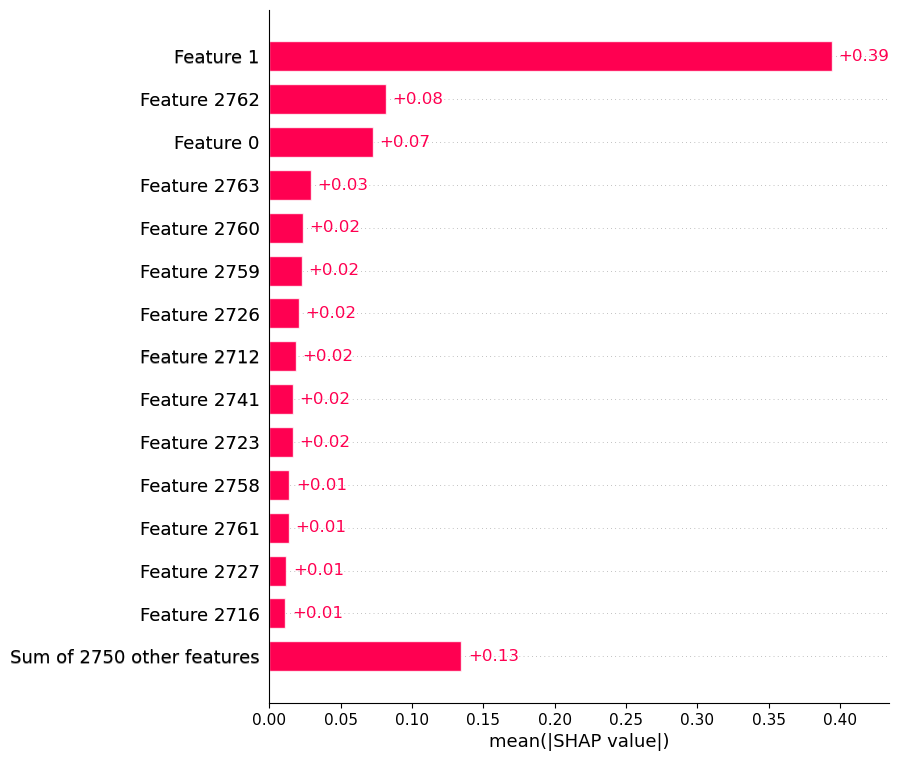

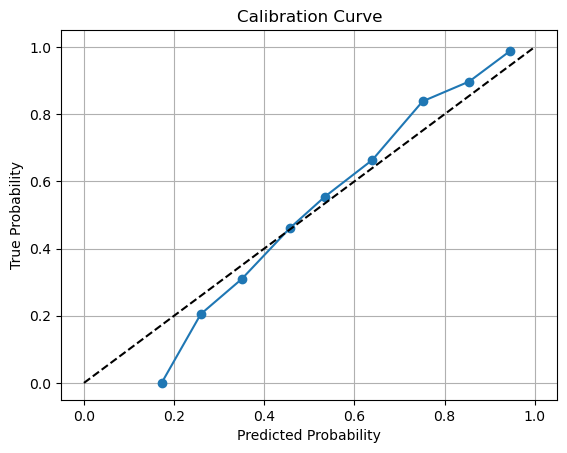

95% AUC CI: [0.669, 0.701]
Top 10 States by AUC:
         AUC
SD  0.923077
MT  0.892308
ID  0.852941
IA  0.732323
WA  0.704710
NC  0.697800
WY  0.681818
OK  0.672433
KS  0.671569
KY  0.669719
Logistic Regression AUC: 0.6618
Random Forest AUC: 0.6729
Neural Network AUC: 0.6382


<Figure size 1000x600 with 0 Axes>

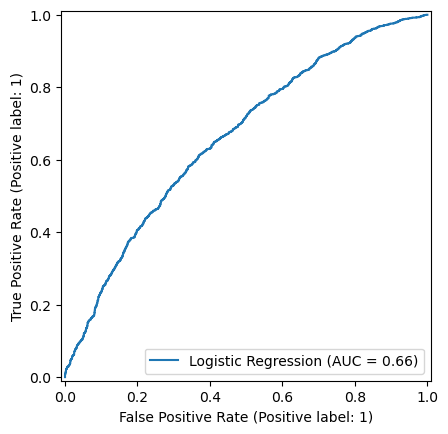

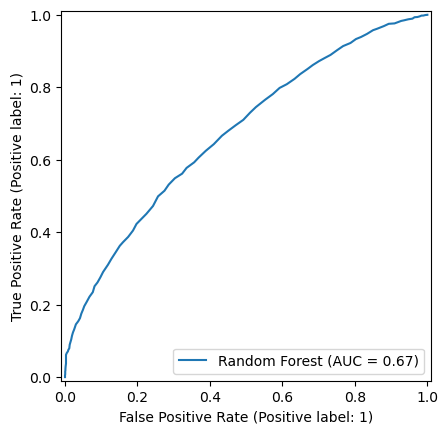

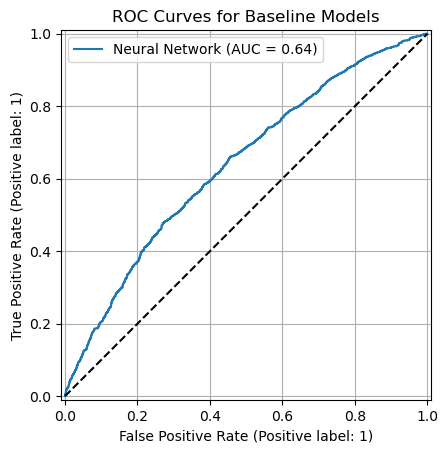

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (roc_auc_score, confusion_matrix, classification_report,
                             RocCurveDisplay, roc_curve, accuracy_score, brier_score_loss)
from sklearn.calibration import calibration_curve
import shap
from sklearn.utils import resample
import joblib
import optuna

# Load and clean dataset
df = pd.read_csv("Hospital_Readmissions_Reduction_Program_Hospital.csv")
leaky_cols = [
    'Predicted Readmission Rate',
    'Expected Readmission Rate',
    'Number of Readmissions',
    'Footnote',
    'Start Date',
    'End Date'
]
df.drop(columns=leaky_cols, inplace=True, errors='ignore')
df = df.dropna(subset=['Excess Readmission Ratio'])
df['Excess Readmission Ratio'] = df['Excess Readmission Ratio'].astype(float)
df['readmit_flag'] = (df['Excess Readmission Ratio'] > 1.0).astype(int)
X = df.drop(columns=['Excess Readmission Ratio', 'readmit_flag'])
y = df['readmit_flag']

# Define feature types
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# Preprocessing pipeline
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Hyperparameter tuning for XGBoost
def objective(trial):
    from xgboost import XGBClassifier
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'eval_metric': 'logloss',
        'use_label_encoder': False,
        'random_state': 42
    }
    clf = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(**params))
    ])
    scores = cross_val_score(clf, X_train, y_train, cv=3, scoring='roc_auc')
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Train final model
from xgboost import XGBClassifier
best_params = study.best_params
best_params['eval_metric'] = 'logloss'
best_params['use_label_encoder'] = False
best_params['random_state'] = 42
final_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(**best_params))
])
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

# Evaluation
print("AUC:", roc_auc_score(y_test, y_proba))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Brier Score:", brier_score_loss(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# SHAP Explainability
explainer = shap.Explainer(final_model.named_steps['classifier'])
X_test_preprocessed = final_model.named_steps['preprocessor'].transform(X_test)
shap_values = explainer(X_test_preprocessed)
shap.plots.beeswarm(shap_values, max_display=15)
shap.plots.bar(shap_values, max_display=15)

# Calibration Curve
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Calibration Curve")
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.grid()
plt.show()

# Bootstrap AUC CI
bootstrapped_aucs = []
for _ in range(1000):
    X_resampled, y_resampled = resample(X_test, y_test)
    y_proba_resampled = final_model.predict_proba(X_resampled)[:, 1]
    bootstrapped_aucs.append(roc_auc_score(y_resampled, y_proba_resampled))
ci_low, ci_high = np.percentile(bootstrapped_aucs, [2.5, 97.5])
print(f"95% AUC CI: [{ci_low:.3f}, {ci_high:.3f}]")

# Subgroup Fairness by State
X_test_copy = X_test.copy()
X_test_copy['y_true'] = y_test.values
X_test_copy['y_proba'] = y_proba
state_aucs = {}
for state in X_test_copy['State'].unique():
    subset = X_test_copy[X_test_copy['State'] == state]
    if len(subset['y_true'].unique()) == 2:
        auc = roc_auc_score(subset['y_true'], subset['y_proba'])
        state_aucs[state] = auc
state_auc_df = pd.DataFrame.from_dict(state_aucs, orient='index', columns=['AUC'])
print("Top 10 States by AUC:")
print(state_auc_df.sort_values(by="AUC", ascending=False).head(10))

# Train and compare baseline models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(50, 30), max_iter=300, random_state=42)
}
plt.figure(figsize=(10, 6))
for name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipe.fit(X_train, y_train)
    y_prob = pipe.predict_proba(X_test)[:, 1]
    RocCurveDisplay.from_predictions(y_test, y_prob, name=name)
    print(f"{name} AUC: {roc_auc_score(y_test, y_prob):.4f}")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves for Baseline Models")
plt.legend()
plt.grid(True)
plt.show()

True Positive Savings: ₹4,940,000
False Positive Costs: ₹593,000
Net Utility: ₹4,347,000


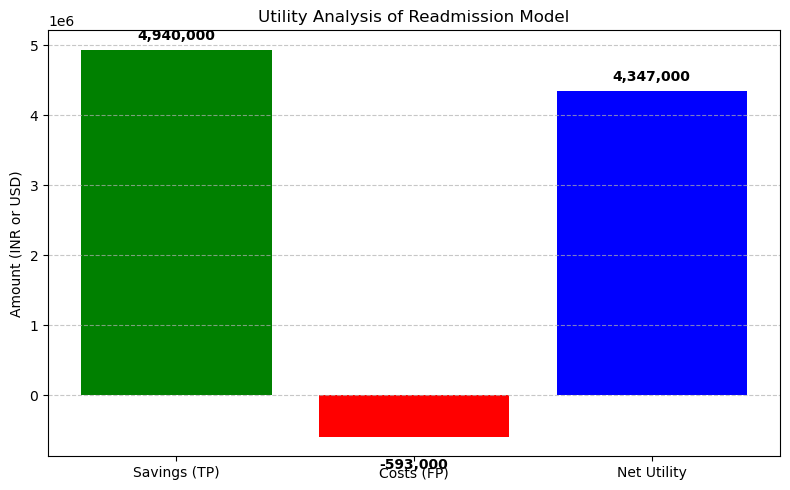

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# === Step 1: Define Utility Parameters ===
cost_per_readmission = 5000        # cost incurred for one readmission
cost_per_intervention = 1000       # cost to intervene on a predicted high-risk patient

# === Step 2: Calculate TP, FP, etc. from your model ===
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# === Step 3: Calculate savings and losses ===
true_positive_savings = tp * cost_per_readmission
false_positive_costs = fp * cost_per_intervention
net_savings = true_positive_savings - false_positive_costs

print(f"True Positive Savings: ₹{true_positive_savings:,}")
print(f"False Positive Costs: ₹{false_positive_costs:,}")
print(f"Net Utility: ₹{net_savings:,}")

# === Step 4: Visualize as stacked bar ===
labels = ['Savings (TP)', 'Costs (FP)', 'Net Utility']
values = [true_positive_savings, -false_positive_costs, net_savings]
colors = ['green', 'red', 'blue']

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, values, color=colors)
plt.title("Utility Analysis of Readmission Model")
plt.ylabel("Amount (INR or USD)")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.annotate(f"{height:,.0f}",
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5 if height > 0 else -15),
                 textcoords="offset points",
                 ha='center', va='bottom' if height > 0 else 'top',
                 fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()
